In [12]:
import tarfile

# Specify the path to your tar archive file
tar_file_path = "MovieSummaries.tar"

# Specify the directory where you want to extract the files
output_directory = "data/"

# Open the tar file
with tarfile.open(tar_file_path, "r") as tar:
    # Extract all the files in the archive to the output directory
    tar.extractall(output_directory)

print("All files extracted to", output_directory)


All files extracted to data/


In [15]:
# Data exploration

import pandas as pd

# Load the TSV file into a DataFrame
tsv_file_path = "data/MovieSummaries/character.metadata.tsv"
df_character = pd.read_csv(tsv_file_path, sep='\t')

print(df_character.columns)


Index(['975900', '/m/03vyhn', '2001-08-24', 'Akooshay', '1958-08-26', 'F',
       '1.62', 'Unnamed: 7', 'Wanda De Jesus', '42', '/m/0bgchxw',
       '/m/0bgcj3x', '/m/03wcfv7'],
      dtype='object')


In [58]:
# Data exploration
import pandas as pd
import json

# Load the TSV file into a DataFrame
tsv_file_path = "data/MovieSummaries/movie.metadata.tsv"
df_movies = pd.read_csv(tsv_file_path, sep='\t')
print(df_movies[:4])
new_column_names = [
    'WikipediaMovieID',
    'FreebaseMovieID',
    'MovieName',
    'MovieReleaseDate',
    'MovieBoxOfficeRevenue',
    'MovieRuntime',
    'MovieLanguages',
    'MovieCountries',
    'MovieGenres'
]

df_movies.columns = new_column_names

def get_first(mapping):
    mapping = json.loads(mapping)
    if mapping:
        return next(iter(mapping.values()))
    return None

def replace(text):
    return str(text).replace(" Language", "").replace(" language", "")
 
# Apply the function to get the first country name
df_movies['MovieCountries']= df_movies['MovieCountries'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(replace)

df_movies['MovieGenres']= df_movies['MovieGenres'].apply(get_first)

# Show the DataFrame

print(df_movies['MovieLanguages'])



     975900   /m/03vyhn                                     Ghosts of Mars  \
0   3196793   /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
1  28463795  /m/0crgdbh                                        Brun bitter   
2   9363483  /m/0285_cd                                   White Of The Eye   
3    261236   /m/01mrr1                                  A Woman in Flames   

   2001-08-24  14010832   98.0  {"/m/02h40lc": "English Language"}  \
0  2000-02-16       NaN   95.0  {"/m/02h40lc": "English Language"}   
1        1988       NaN   83.0  {"/m/05f_3": "Norwegian Language"}   
2        1987       NaN  110.0  {"/m/02h40lc": "English Language"}   
3        1983       NaN  106.0   {"/m/04306rv": "German Language"}   

   {"/m/09c7w0": "United States of America"}  \
0  {"/m/09c7w0": "United States of America"}   
1                     {"/m/05b4w": "Norway"}   
2             {"/m/07ssc": "United Kingdom"}   
3                    {"/m/0345h": "Germany"}   

  {"/m/01jfsb": "

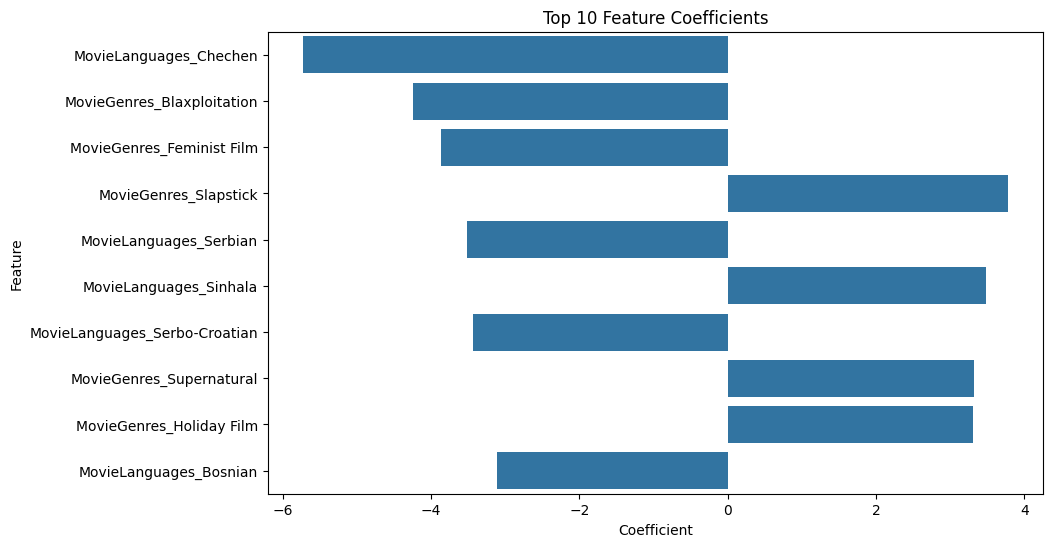

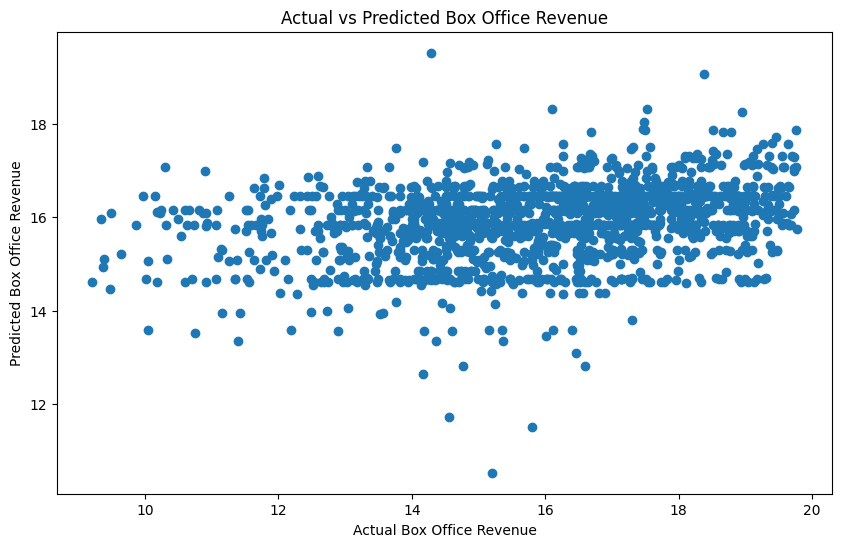

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Replace this with your actual dataframe, for example, df_movies = pd.read_csv(tsv_file_path, sep='\t')
# df_movies = ...
from scipy import stats
import numpy as np


# Now df_movies_clean, X_clean, and y_clean are free from outliers.

# Define features and target variable
X = df_movies[['MovieLanguages', 'MovieGenres']]
y = df_movies['MovieBoxOfficeRevenue']
# Calculate Z-scores for 'MovieBoxOfficeRevenue'

z_scores = np.abs(stats.zscore(df_movies['MovieBoxOfficeRevenue']))

# Get boolean array: True if outlier, False otherwise
outliers = z_scores > 3

# Remove outliers
df_movies_clean = df_movies[~outliers]
X = X[~outliers]
y = y[~outliers]
y = np.log(y + 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['MovieLanguages', 'MovieGenres'])
    ])

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LinearRegression())])

# Fit model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Get coefficients
regressor = pipeline.named_steps['classifier']
feature_names = (pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out()).tolist()

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': regressor.coef_
})

# Sort by the absolute value of the Coefficient for better visualization
coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature')
plt.title('Top 10 Feature Coefficients')
plt.show()

# Plot predicted vs actual box office revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Box Office Revenue')
plt.ylabel('Predicted Box Office Revenue')
plt.title('Actual vs Predicted Box Office Revenue')
plt.show()


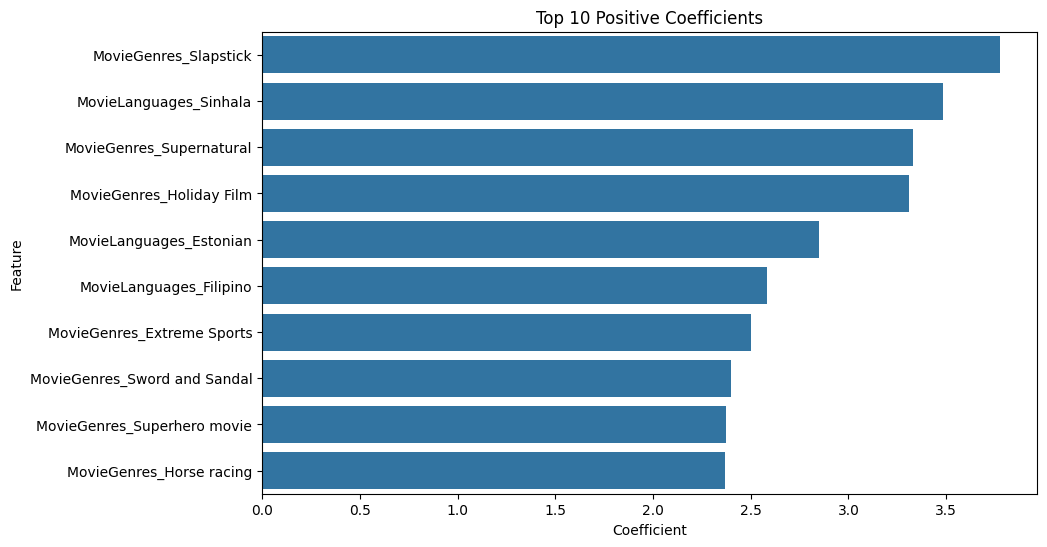

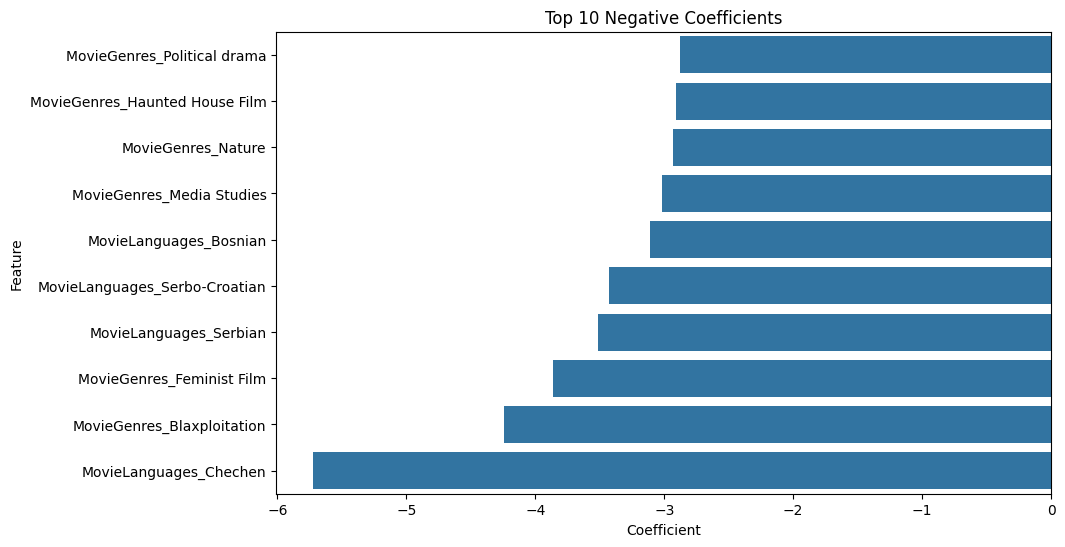

In [85]:
# Sort the DataFrame by the coefficients
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Top 10 positive coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title('Top 10 Positive Coefficients')
plt.show()

# Top 10 negative coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.tail(10))
plt.title('Top 10 Negative Coefficients')
plt.show()

In [52]:
import numpy as np
print(np.sum(df_movies['MovieBoxOfficeRevenue']))


403180434659.0


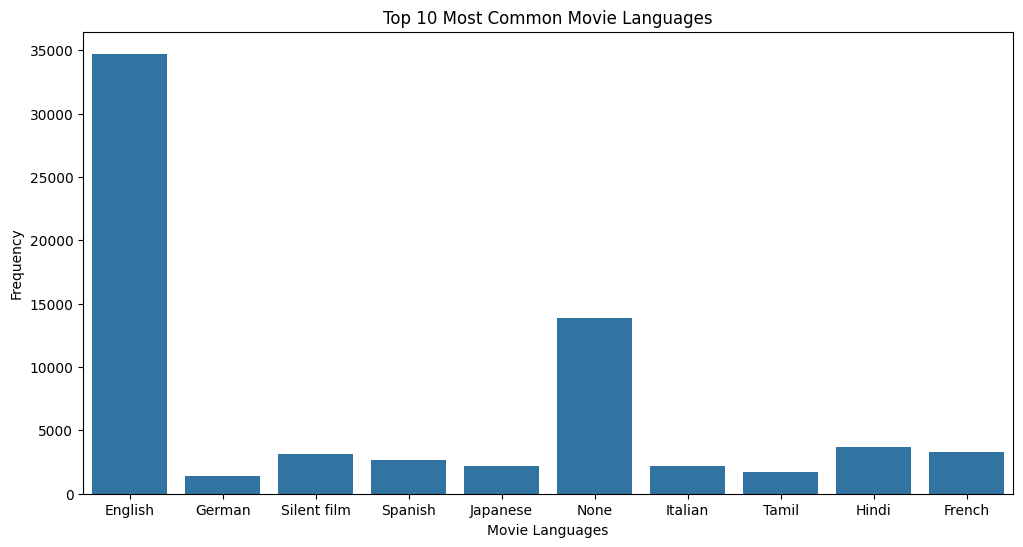

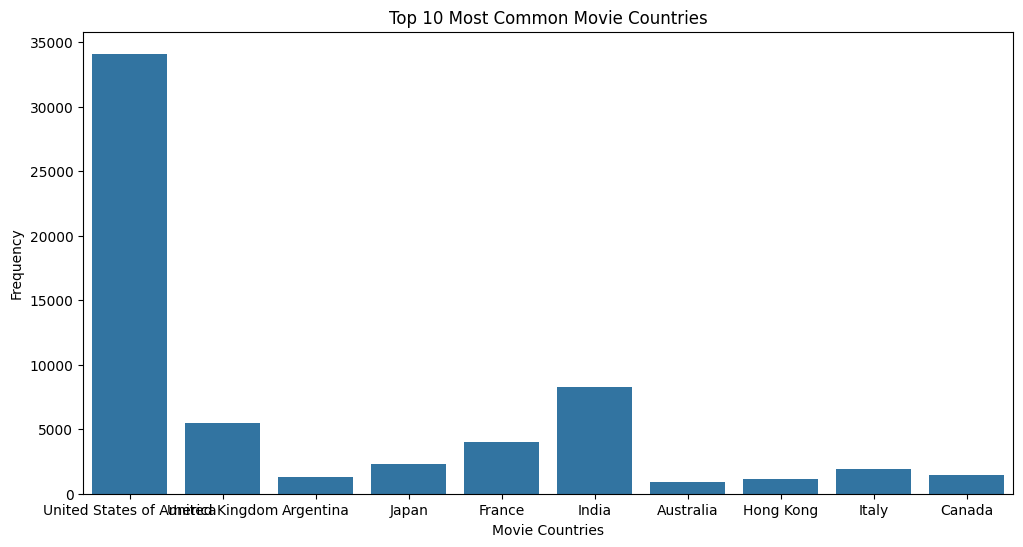

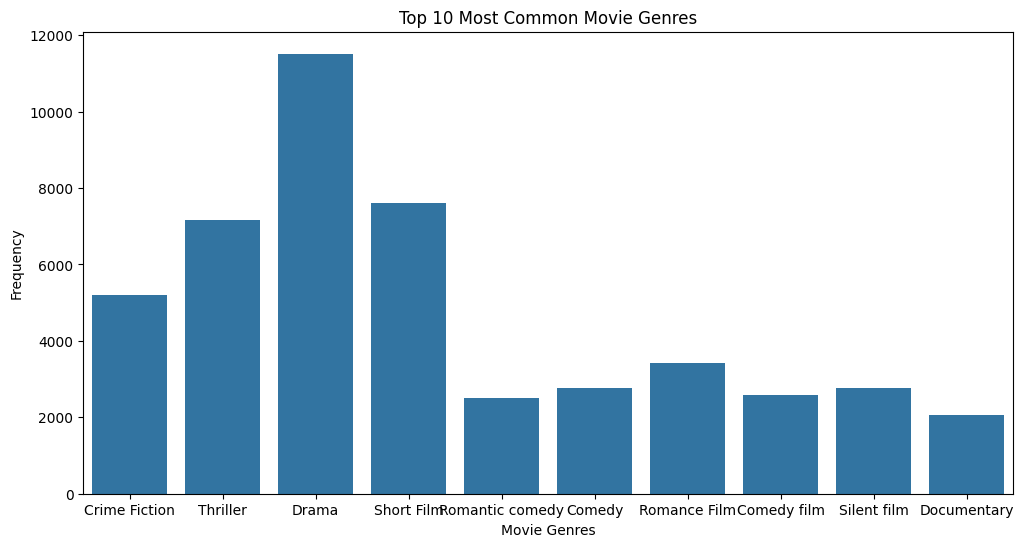

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Find the 10 most common MovieLanguages
common_languages = df_movies['MovieLanguages'].value_counts().nlargest(10).index

# Plotting for the 10 most common MovieLanguages
plt.figure(figsize=(12, 6))
sns.countplot(data=df_movies[df_movies['MovieLanguages'].isin(common_languages)], x='MovieLanguages')
plt.title('Top 10 Most Common Movie Languages')
plt.xlabel('Movie Languages')
plt.ylabel('Frequency')
plt.show()

# Find the 10 most common MovieCountries
common_countries = df_movies['MovieCountries'].value_counts().nlargest(10).index

# Plotting for the 10 most common MovieCountries
plt.figure(figsize=(12, 6))
sns.countplot(data=df_movies[df_movies['MovieCountries'].isin(common_countries)], x='MovieCountries')
plt.title('Top 10 Most Common Movie Countries')
plt.xlabel('Movie Countries')
plt.ylabel('Frequency')
plt.show()

# Find the 10 most common MovieGenres
common_genres = df_movies['MovieGenres'].value_counts().nlargest(10).index

# Plotting for the 10 most common MovieGenres
plt.figure(figsize=(12, 6))
sns.countplot(data=df_movies[df_movies['MovieGenres'].isin(common_genres)], x='MovieGenres')
plt.title('Top 10 Most Common Movie Genres')
plt.xlabel('Movie Genres')
plt.ylabel('Frequency')
plt.show()


In [20]:
# Data exploration
import pandas as pd

# Load the TSV file into a DataFrame
tsv_file_path = "data/MovieSummaries/name.clusters.txt"
df_name = pd.read_csv(tsv_file_path, sep='\t')

print(df_movies.columns)
print(df_movies)


Index(['975900', '/m/03vyhn', 'Ghosts of Mars', '2001-08-24', '14010832',
       '98.0', '{"/m/02h40lc": "English Language"}',
       '{"/m/09c7w0": "United States of America"}',
       '{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'],
      dtype='object')
         975900   /m/03vyhn  \
0       3196793   /m/08yl5d   
1      28463795  /m/0crgdbh   
2       9363483  /m/0285_cd   
3        261236   /m/01mrr1   
4      13696889  /m/03cfc81   
...         ...         ...   
81735  35228177  /m/0j7hxnt   
81736  34980460  /m/0g4pl34   
81737   9971909  /m/02pygw1   
81738    913762   /m/03pcrp   
81739  12476867  /m/02w7zz8   

                                          Ghosts of Mars  2001-08-24  \
0      Getting Away with Murder: The JonBenét Ramsey ...  2000-02-16   
1                                            Brun bitter        1988   
2           

In [19]:
# Data exploration
import pandas as pd

# Load the TSV file into a DataFrame
tsv_file_path = "data/MovieSummaries/plot_summaries.txt"
df_name = pd.read_csv(tsv_file_path, sep='\t')

print(df_movies.columns)
print(df_movies)

Index(['975900', '/m/03vyhn', 'Ghosts of Mars', '2001-08-24', '14010832',
       '98.0', '{"/m/02h40lc": "English Language"}',
       '{"/m/09c7w0": "United States of America"}',
       '{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'],
      dtype='object')
         975900   /m/03vyhn  \
0       3196793   /m/08yl5d   
1      28463795  /m/0crgdbh   
2       9363483  /m/0285_cd   
3        261236   /m/01mrr1   
4      13696889  /m/03cfc81   
...         ...         ...   
81735  35228177  /m/0j7hxnt   
81736  34980460  /m/0g4pl34   
81737   9971909  /m/02pygw1   
81738    913762   /m/03pcrp   
81739  12476867  /m/02w7zz8   

                                          Ghosts of Mars  2001-08-24  \
0      Getting Away with Murder: The JonBenét Ramsey ...  2000-02-16   
1                                            Brun bitter        1988   
2           